# Map Compression for Stability

In [1]:
import os
import sys
from pathlib import Path

repo_root = Path(os.getcwd()).parent
sys.path.insert(0, str(repo_root))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator, SymmetricalLogLocator

from pipeline import harmony
from harmonia.algorithms import DiscreteSpectrum
from harmonia.cosmology import BaseModel
from harmonia.reader import Couplings, SphericalCorrelator

plt.style.use(harmony)

In [3]:
storage = repo_root/"storage"/"processed"/"survey_products"

disc = DiscreteSpectrum(500., 'd', 0.04)

couplings = Couplings.load(
    storage/
    "couplings-(rmax=500.0,kmax=0.055,mask=random0_BOSS_DR12v5_CMASS_North,selection=[100.0,500.0]).npz"
)

cosmo = BaseModel(repo_root/"storage"/"external"/"cosmology"/"simulation-GadgetAHF.txt")

model = SphericalCorrelator(disc, redshift=1., cosmo=cosmo, couplings=couplings)

[2020-07-29 04:14:51 (+0:00:01) INFO] DiscreteSpectrum(dirichlet, boundary=500.0, 0.0<=wavenumber<=0.04) computed: 15 degrees and 456 modes in total.
[2020-07-29 04:14:52 (+0:00:03) INFO] Created cosmological model with parameters:
{'Omega0_b': 0.044, 'Omega0_cdm': 0.226, 'h': 0.7, 'sigma8': 0.8}.
[2020-07-29 04:14:55 (+0:00:05) INFO] Compiling shot noise levels...
Shot noise level compilation: 100%|██████████| 104196/104196 [00:59<00:00, 1765.98it/s]
[2020-07-29 04:15:54 (+0:01:05) INFO] ... compiled shot noise levels.
[2020-07-29 04:15:54 (+0:01:05) INFO] Compiling fixed angular sums...
Angular sum compilation: 100%|██████████| 25425/25425 [01:03<00:00, 401.85it/s]
[2020-07-29 04:16:58 (+0:02:08) INFO] ... compiled fixed angular sums.


In [4]:
pivot = 'spectral'
n_bar = 4.75e-5
contrast = 50.
bias=3.5

fiducial_covariance = model.correlator_matrix(
    pivot, b_1=bias, f_nl=0., nbar=n_bar, contrast=contrast, report_progress=True
)

low_covariance = model.correlator_matrix(
    pivot, b_1=bias, f_nl=-100., nbar=n_bar, contrast=contrast, report_progress=True
)

high_covariance = model.correlator_matrix(
    pivot, b_1=bias, f_nl=100., nbar=n_bar, contrast=contrast, report_progress=True
)

[2020-07-29 04:17:20 (+0:02:31) INFO] Progress for the single 'correlator matrix' process: 25% computed.
[2020-07-29 04:17:40 (+0:02:50) INFO] Progress for the single 'correlator matrix' process: 50% computed.
[2020-07-29 04:18:00 (+0:03:10) INFO] Progress for the single 'correlator matrix' process: 75% computed.
[2020-07-29 04:18:21 (+0:03:32) INFO] Progress for the single 'correlator matrix' process: 100% computed.
[2020-07-29 04:18:45 (+0:03:55) INFO] Progress for the single 'correlator matrix' process: 25% computed.
[2020-07-29 04:19:07 (+0:04:17) INFO] Progress for the single 'correlator matrix' process: 50% computed.
[2020-07-29 04:19:29 (+0:04:39) INFO] Progress for the single 'correlator matrix' process: 75% computed.
[2020-07-29 04:19:51 (+0:05:01) INFO] Progress for the single 'correlator matrix' process: 100% computed.
[2020-07-29 04:20:19 (+0:05:29) INFO] Progress for the single 'correlator matrix' process: 25% computed.
[2020-07-29 04:20:45 (+0:05:55) INFO] Progress for th

In [5]:
fid_eigvals, fid_eigvecs = np.linalg.eigh(fiducial_covariance)
low_eigvals, low_eigvecs = np.linalg.eigh(low_covariance)
high_eigvals, high_eigvecs = np.linalg.eigh(high_covariance)

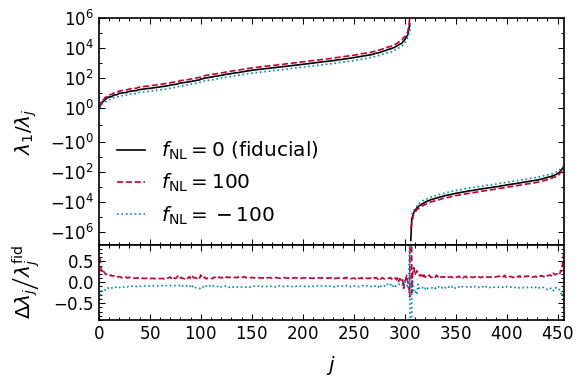

In [14]:
red, blue = '#C40233', '#0087BD'

eigen_indices = 1 + np.arange(np.size(fid_eigvals))

flip_idx_fid = np.size(fid_eigvals) - np.searchsorted(fid_eigvals, 0., side='right')
flip_idx_high = np.size(high_eigvals) - np.searchsorted(high_eigvals, 0., side='right')
flip_idx_low = np.size(low_eigvals) - np.searchsorted(low_eigvals, 0., side='right')

lambda_fid = n_bar**2 * fid_eigvals[::-1]
lambda_low = n_bar**2 * low_eigvals[::-1]
lambda_high = n_bar**2 * high_eigvals[::-1]

fig = plt.figure(figsize=(6., 4.), dpi=100)

main = plt.subplot2grid((4, 1), (0, 0), rowspan=3)

for section, lgd in zip([slice(None, flip_idx_fid), slice(flip_idx_fid, None)], [True, False]):
    main.plot(
        eigen_indices[section], (np.max(lambda_fid)/lambda_fid)[section], 
        ls='-', c='k', label=r"$f_\mathrm{NL} = 0$ (fiducial)" if lgd else None
    )
for section, lgd in zip([slice(None, flip_idx_high), slice(flip_idx_high, None)], [True, False]):
    main.plot(
        eigen_indices[section], (np.max(lambda_high)/lambda_high)[section], 
        ls='--', c=red, label=r"$f_\mathrm{NL} = 100$" if lgd else None
    )
for section, lgd in zip([slice(None, flip_idx_low), slice(flip_idx_low, None)], [True, False]):
    main.plot(
        eigen_indices[section], (np.max(lambda_low)/lambda_low)[section], 
        ls=':', c=blue, label=r"$f_\mathrm{NL} = -100$" if lgd else None
    )

# main.axhspan(0, 10**2, fc='0.75', ec='none', alpha=0.5)
# main.axvline(flip_idx_fid, ls=':')

main.legend(handlelength=1.4)
main.tick_params(which='both', labelbottom=False)
main.set_yscale('symlog', linthresh=1)
main.set_yticks(np.r_[-np.logspace(8., 2., 4), [-1, 1], np.logspace(2., 8., 4)])
main.set_ylim(-10**6.85, 10**6.);
main.set_ylabel(r"$\lambda_1/\lambda_j$", labelpad=8);

error = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=main)

error.plot(eigen_indices, (lambda_high/lambda_fid) - 1, c=red, ls='--')
error.plot(eigen_indices, (lambda_low/lambda_fid) - 1, c=blue, ls=':')

error.set_xticks(np.arange(0, 460, 50))
error.set_yticks(np.linspace(-1., 1., 5))
error.xaxis.set_minor_locator(AutoMinorLocator())
error.yaxis.set_minor_locator(AutoMinorLocator())
error.set_xlim(0, 456);
error.set_ylim(-0.9, 0.9);
error.set_xlabel(r"$j$", labelpad=8);
error.set_ylabel(r"$\Delta \lambda_j \left/ \lambda_j^\mathrm{fid} \right.$", labelpad=8);

fig.savefig(repo_root/"publication"/"gallery"/"condition_number.pdf")